In [4]:
from pathlib import Path
import numpy as np
import pandas as pd
import hdbscan
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.metrics import silhouette_score, adjusted_rand_score
import seaborn as sns

import folium
import numpy as np
from IPython.display import display

In [5]:
full_df = pd.read_pickle('../../data/processed/state2/left_ios_df.pkl')
print(full_df.columns.tolist())

def assign_manual_label_3class(row):
    angle = row['gyroAngleChange']
    if angle < 60:
        return 0  # Lane Change
    elif angle < 140:
        return 1  # Left Turn
    else:
        return 2  # U-Turn

full_df['manual_label'] = full_df.apply(assign_manual_label_3class, axis=1)

print("Manual label distribution:")
print(full_df['manual_label'].value_counts().sort_index())
print()

print(full_df.columns.tolist())
features = [
    'angle_norm',                        
    'radius_log',                        
    'turn_intensity',                    
    'eventDurationSeconds',            
]
df = full_df[features].copy()
print(df.columns.to_list())
print(df.shape)

['eventSampleSpeed', 'eventDurationSeconds', 'eventStartSpeed', 'eventEndSpeed', 'eventMilesDriven', 'memsMedianLateralAccel', 'gyro_angular_change_per_second', 'gyroAngleChange', 'mems_radius', 'aggressive', 'dv', 'turn_intensity', 'angle_norm', 'radius_log']
Manual label distribution:
manual_label
0    3338
1    9522
2     607
Name: count, dtype: int64

['eventSampleSpeed', 'eventDurationSeconds', 'eventStartSpeed', 'eventEndSpeed', 'eventMilesDriven', 'memsMedianLateralAccel', 'gyro_angular_change_per_second', 'gyroAngleChange', 'mems_radius', 'aggressive', 'dv', 'turn_intensity', 'angle_norm', 'radius_log', 'manual_label']
['angle_norm', 'radius_log', 'turn_intensity', 'eventDurationSeconds']
(13467, 4)


/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_57150/1302670209.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


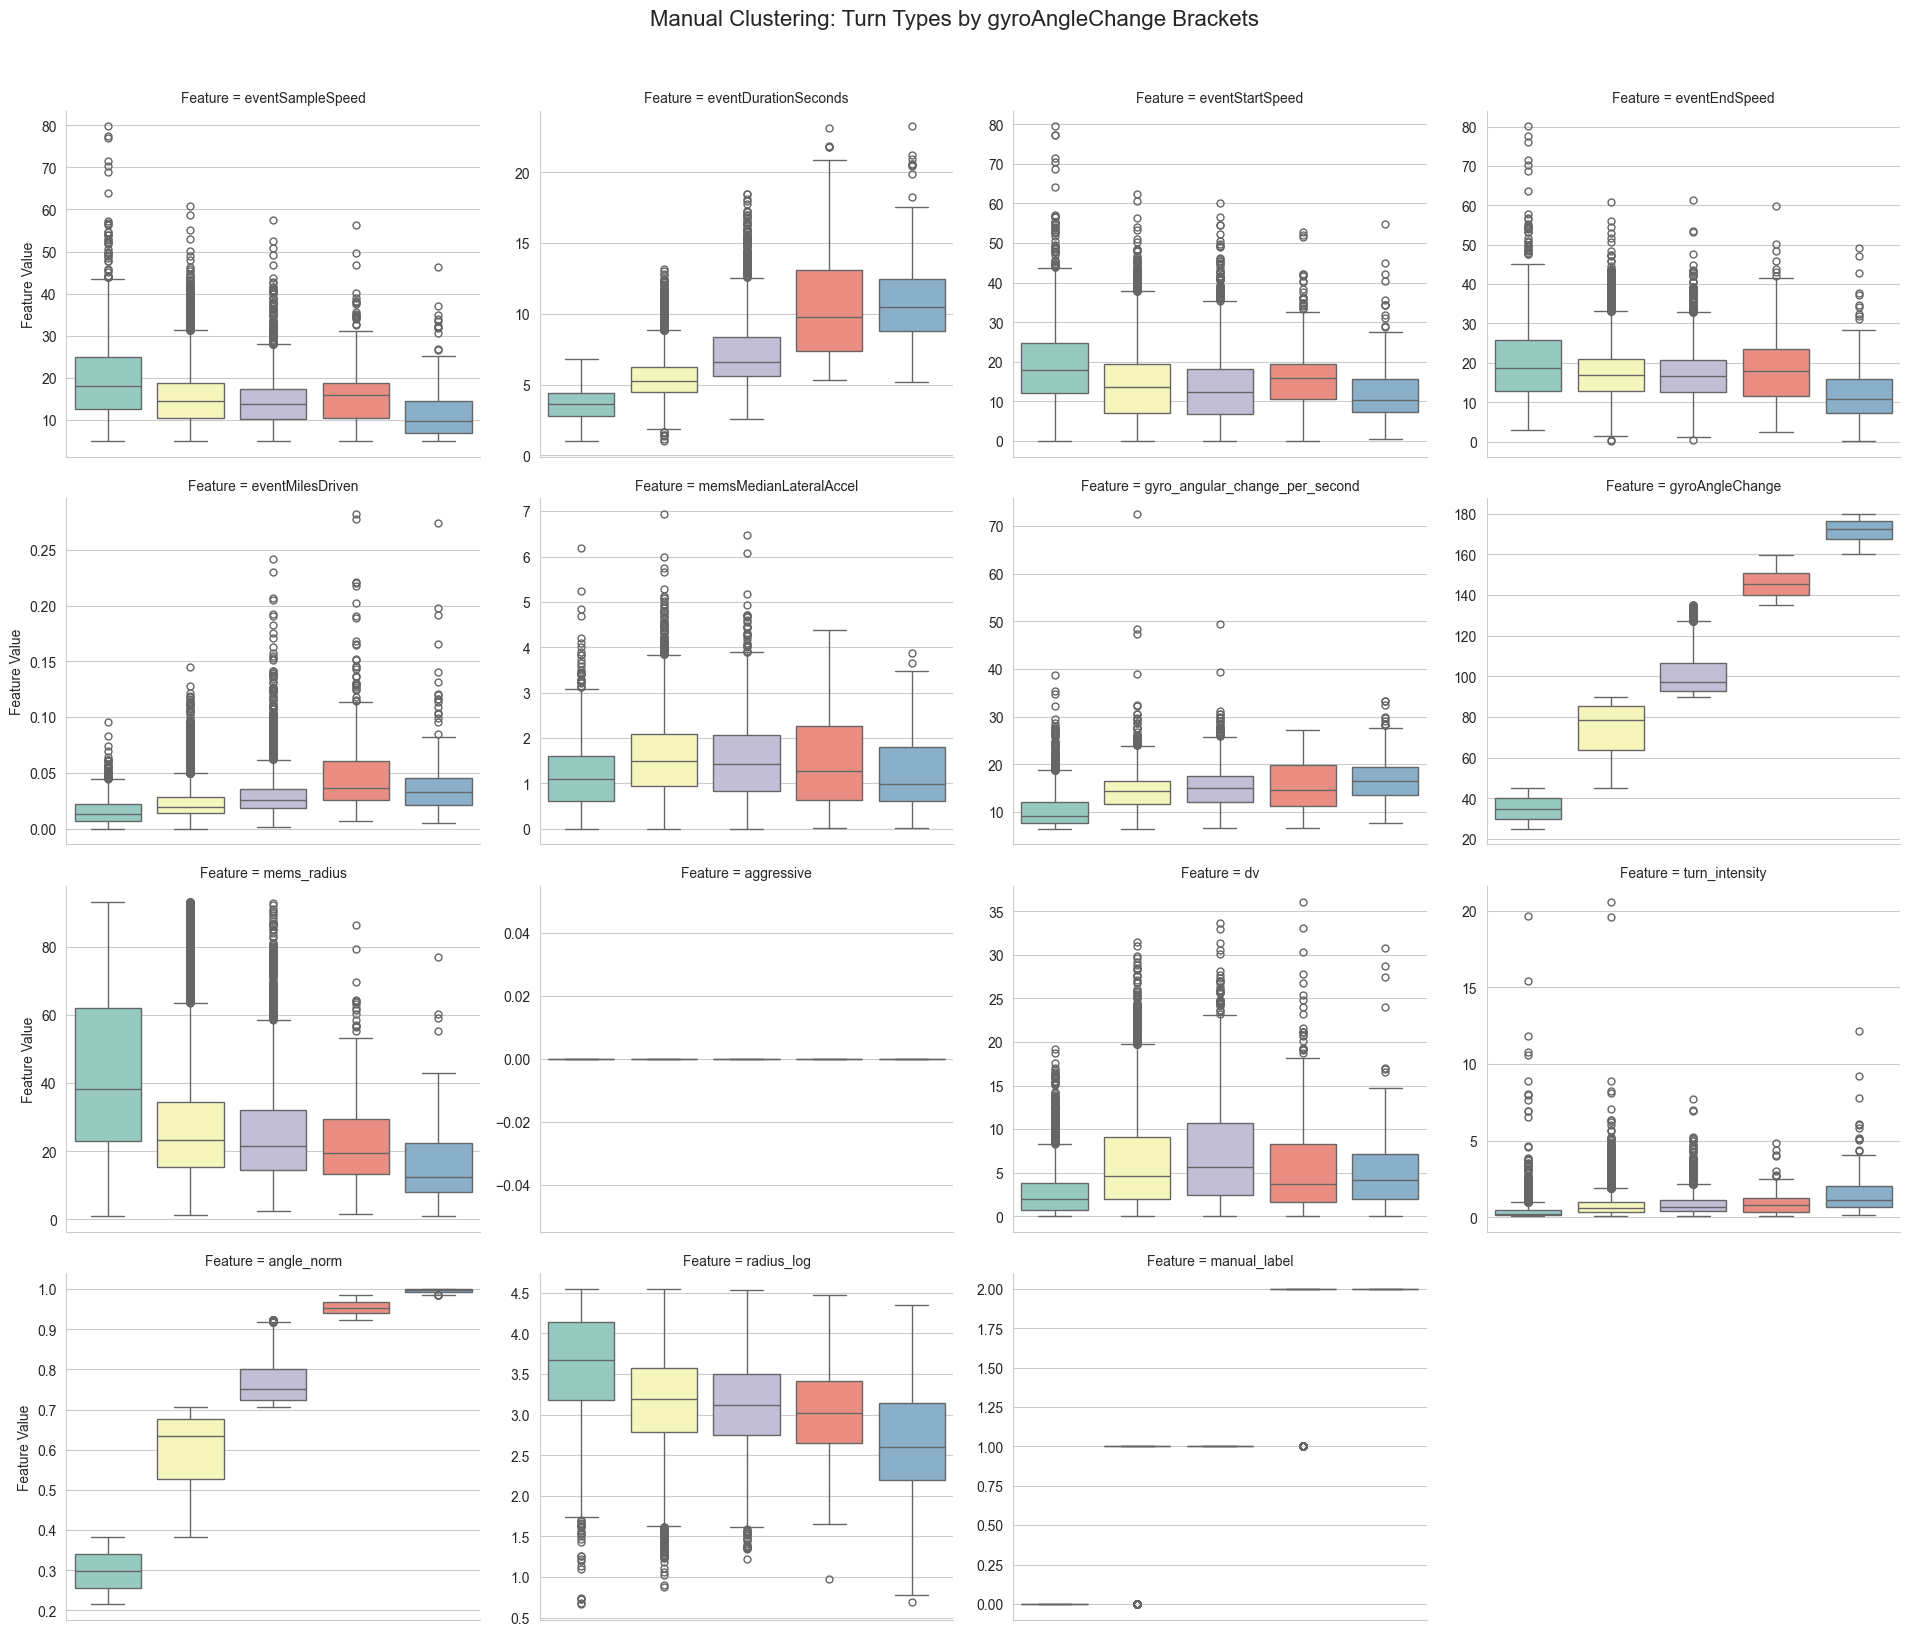


Sample counts per bracket:
Lane Change (0-45°): 1766
Gentle Turn (45-90°): 7973
Left Turn (90-135°): 3056
Sharp Turn (135-160°): 268
U-Turn (160-180°): 203


In [6]:
# Create different angle brackets (manual clustering)
brackets = {
    'Lane Change (0-45°)': full_df[full_df['gyroAngleChange'] <= 45].copy(),
    'Gentle Turn (45-90°)': full_df[(full_df['gyroAngleChange'] > 45) & (full_df['gyroAngleChange'] <= 90)].copy(),
    'Left Turn (90-135°)': full_df[(full_df['gyroAngleChange'] > 90) & (full_df['gyroAngleChange'] <= 135)].copy(),
    'Sharp Turn (135-160°)': full_df[(full_df['gyroAngleChange'] > 135) & (full_df['gyroAngleChange'] <= 160)].copy(),
    'U-Turn (160-180°)': full_df[(full_df['gyroAngleChange'] > 160) & (full_df['gyroAngleChange'] <= 180)].copy(),
}

# Combine all brackets
df_list = []
for bracket_name, df_bracket in brackets.items():
    df_bracket = df_bracket.copy()
    df_bracket['Turn_Type'] = f"{bracket_name}\n(n={len(df_bracket)})"
    df_list.append(df_bracket)

df_comparison = pd.concat(df_list, ignore_index=True)

# Get all numeric columnsn
melt_cols = df_comparison.select_dtypes(include=[np.number]).columns.tolist()

# Melt the dataframe
df_melted = df_comparison[['Turn_Type'] + melt_cols].melt(
    id_vars='Turn_Type',
    var_name='Feature', 
    value_name='Value'
)

# Plot
sns.set_style('whitegrid')
g = sns.catplot(
    data=df_melted,
    x='Turn_Type',
    y='Value',
    col='Feature',
    kind='box',
    col_wrap=4,
    palette='Set3',
    sharey=False,
    height=4,
    aspect=1.2
)

g.fig.suptitle(
    'Manual Clustering: Turn Types by gyroAngleChange Brackets', 
    y=1.02, 
    fontsize=16
)
g.set_axis_labels('', 'Feature Value')
g.set_xticklabels(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

# Print summary stats
print("\nSample counts per bracket:")
for name, df_bracket in brackets.items():
    print(f"{name}: {len(df_bracket)}")

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(X_scaled, columns=df.columns)

In [8]:
def calculate_gini_score(labels) -> float:
    # Exclude HDBSCAN/DBSCAN noise
    labels = np.asarray(labels)
    mask = labels != -1
    if mask.sum() == 0:
        return 0.0
    # Counts per cluster
    counts = np.bincount(labels[mask])
    counts = counts[counts > 0].astype(float)
    if counts.size <= 1:
        return 0.0
    # Pairwise Gini
    G = np.abs(counts[:, None] - counts[None, :]).sum() / (2 * counts.size * counts.sum())
    # Normalize so 1.0 = maximally imbalanced given k clusters
    Gmax = (counts.size - 1) / counts.size
    return float(G / Gmax) if Gmax else 0.0

In [10]:
# k means model
results_list = []


# possible k values
for k in [2, 3, 4, 5]:
    kmeans_final = KMeans(n_clusters=k, random_state=42)
    kmeans_final.fit(X_scaled)
    final_labels = kmeans_final.labels_

    sil_score = silhouette_score(X_scaled, final_labels)
    noise_percentage = 0.0
    gini_score = calculate_gini_score(final_labels)

    results_list.append({
        'model': 'kmeans',
        'sil. #': sil_score,
        'Gini': gini_score,
        'noise %': noise_percentage,
        'clust. #': k
    })    


In [11]:
N_total = X_scaled.shape[0]

In [12]:
# HDBSCAN modeling
for min_samp in [5, 13]:
    for min_cluster_size in range(180, 200):

        if min_samp > min_cluster_size:
            continue

        clusterer = hdbscan.HDBSCAN(min_samples=min_samp, min_cluster_size=min_cluster_size, metric='euclidean')
        clusterer.fit(X_scaled)
        labels = clusterer.labels_
        
        non_noise_mask = labels != -1
        data_non_noise = X_scaled[non_noise_mask]
        labels_non_noise = labels[non_noise_mask]
        n_clusters = len(np.unique(labels_non_noise))

        n_noise = np.sum(labels == -1)
        noise_percentage = (n_noise / N_total) * 100

        sil_score = np.nan
        if noise_percentage < 15 and n_clusters >= 2 and labels_non_noise.size >= 2:
            try:
                sil_score = silhouette_score(X_scaled[non_noise_mask], labels_non_noise)
            except ValueError:
                sil_score = np.nan

        gini_score = calculate_gini_score(labels) 

        results_list.append({
            'model': 'hdbscan',
            'HP (min_samp)': min_samp,
            'HP (min_cluster_size)': min_cluster_size,
            'sil. #': sil_score,
            'Gini': gini_score,
            'noise %': noise_percentage,
            'clust. #': n_clusters
        })


/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.14/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.14/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.14/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.14/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' 

In [14]:
results_df = pd.DataFrame(results_list).sort_values(by=['noise %', 'Gini', 'sil. #', 'clust. #',], ascending=[True, True, False, False])
filtered_results = results_df.reset_index().rename(columns={'index': 'run_id'})
filtered_results = filtered_results[filtered_results['noise %'] <= 0.15]
filtered_results = filtered_results[(filtered_results['clust. #'] >= 2)]
filtered_results = filtered_results[(filtered_results['sil. #'] >= 0.3)]
filtered_results.head(100)

,run_id,model,sil. #,Gini,noise %,clust. #,HP (min_samp),HP (min_cluster_size)
0,1,kmeans,0.317205,0.111458,0.0,3,NaN,NaN
2,2,kmeans,0.350849,0.417539,0.0,4,NaN,NaN
3,3,kmeans,0.323247,0.423888,0.0,5,NaN,NaN


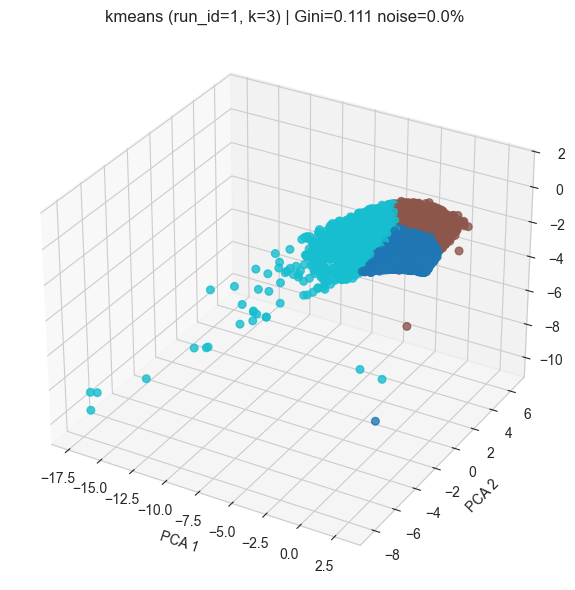

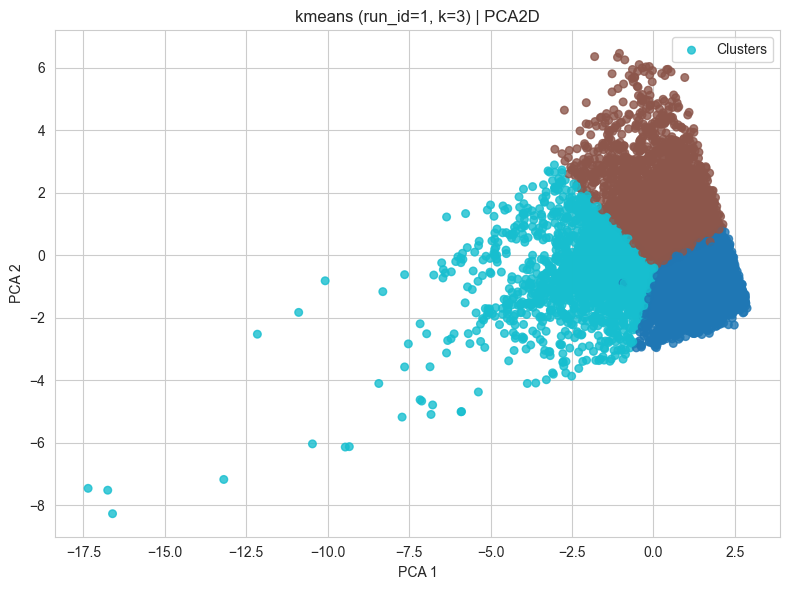

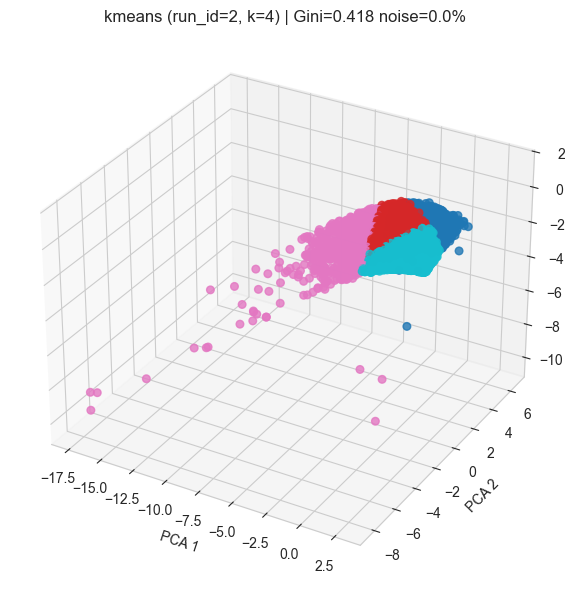

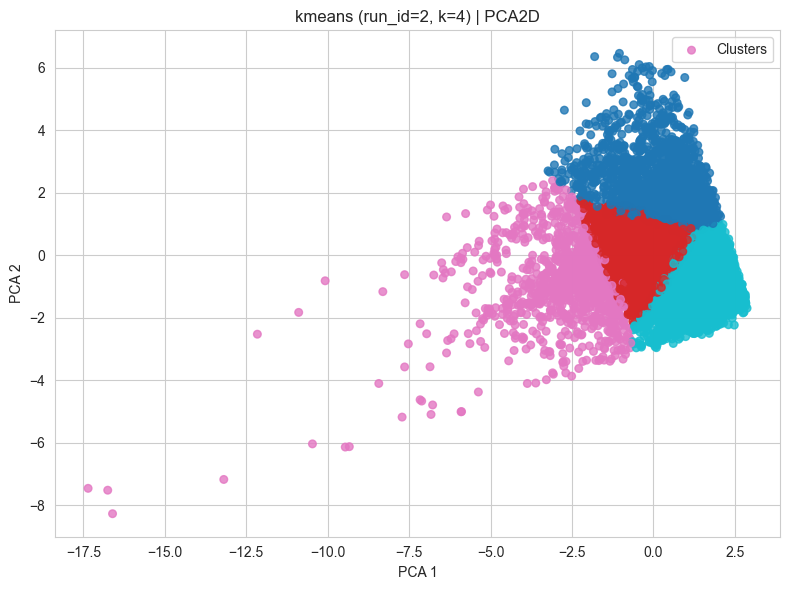

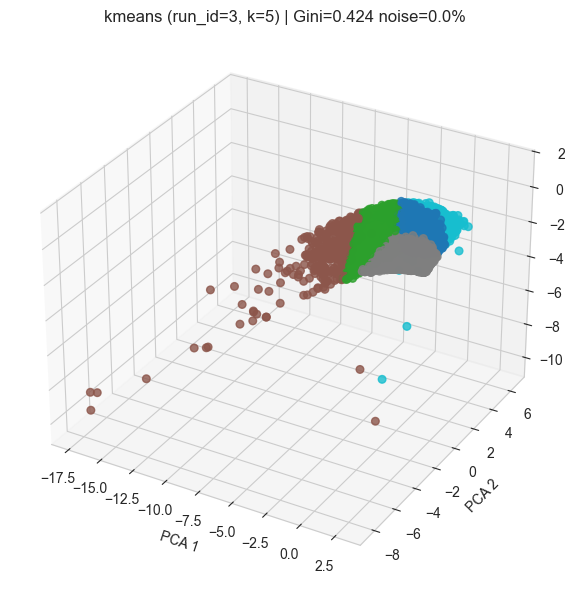

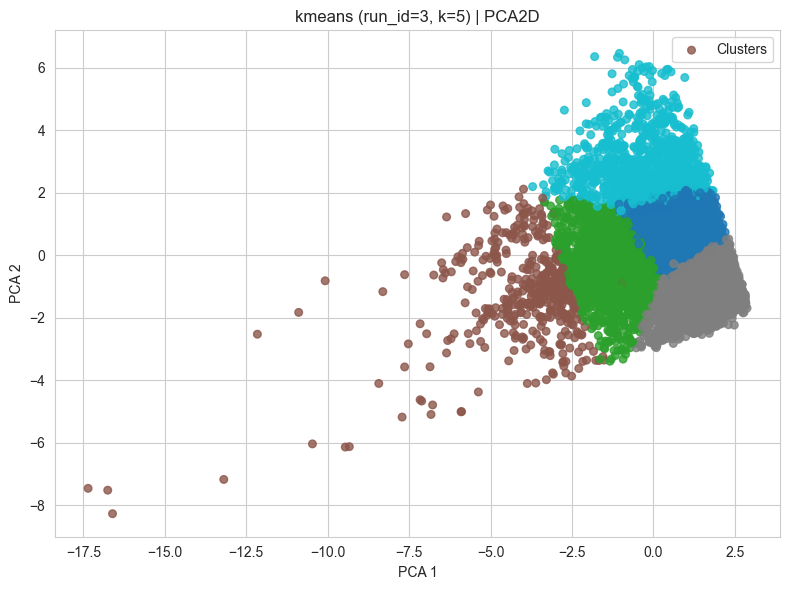

/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_57150/1756224945.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


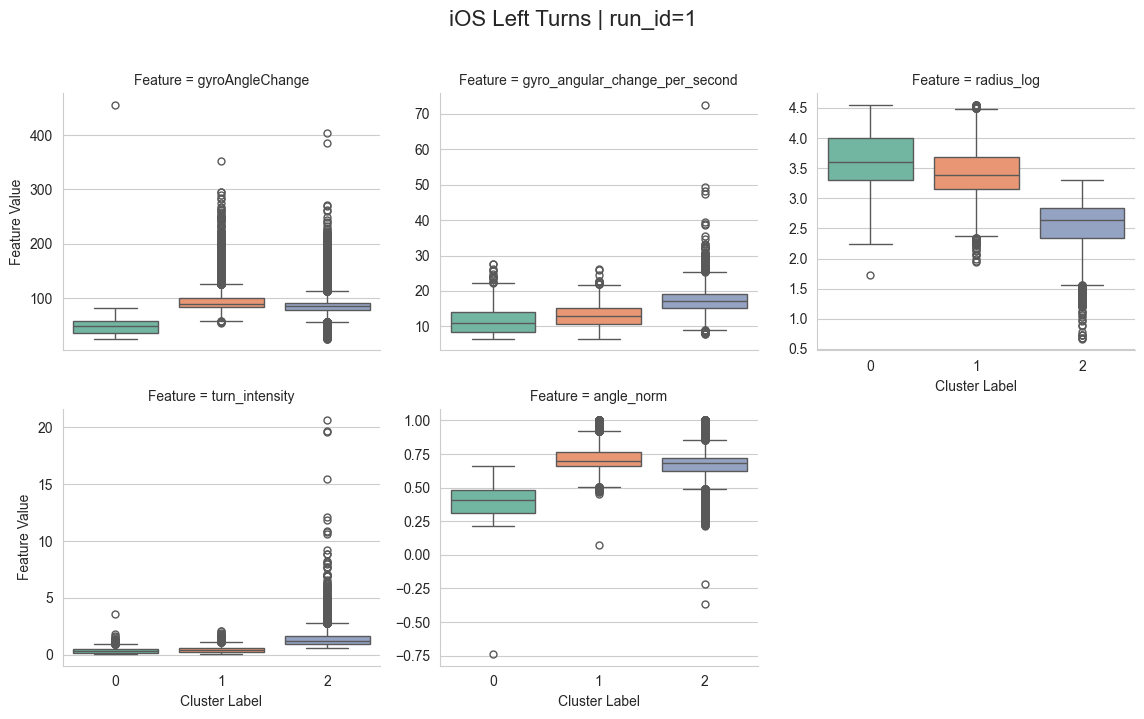

/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_57150/1756224945.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


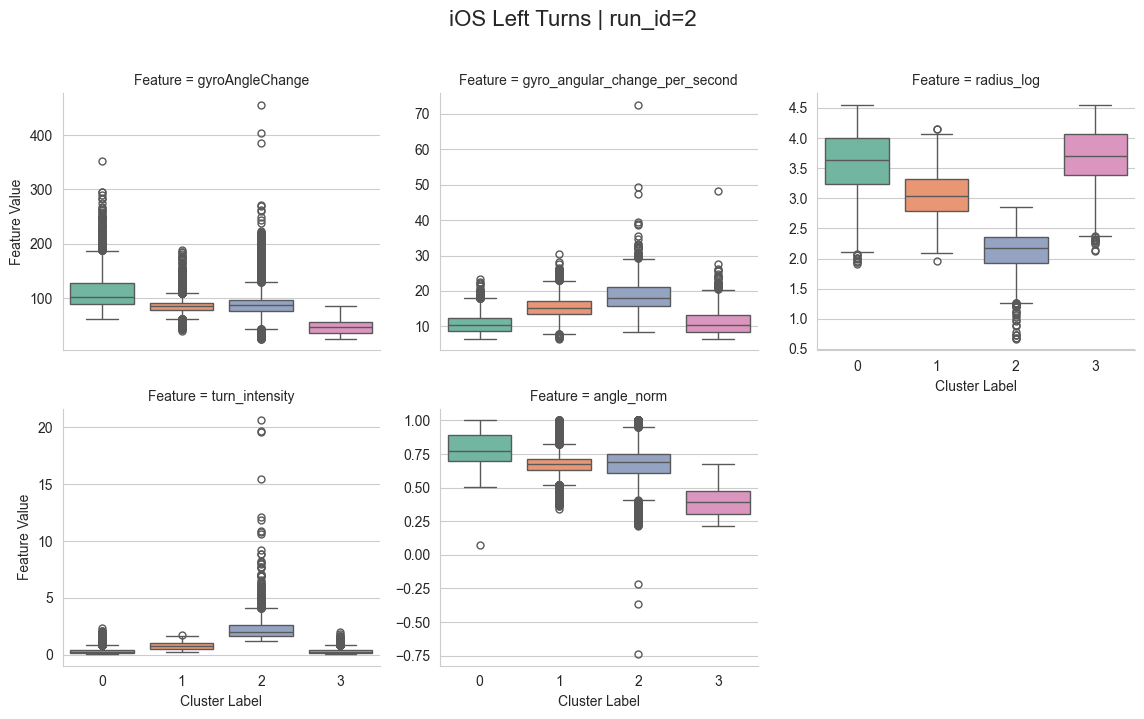

/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_57150/1756224945.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


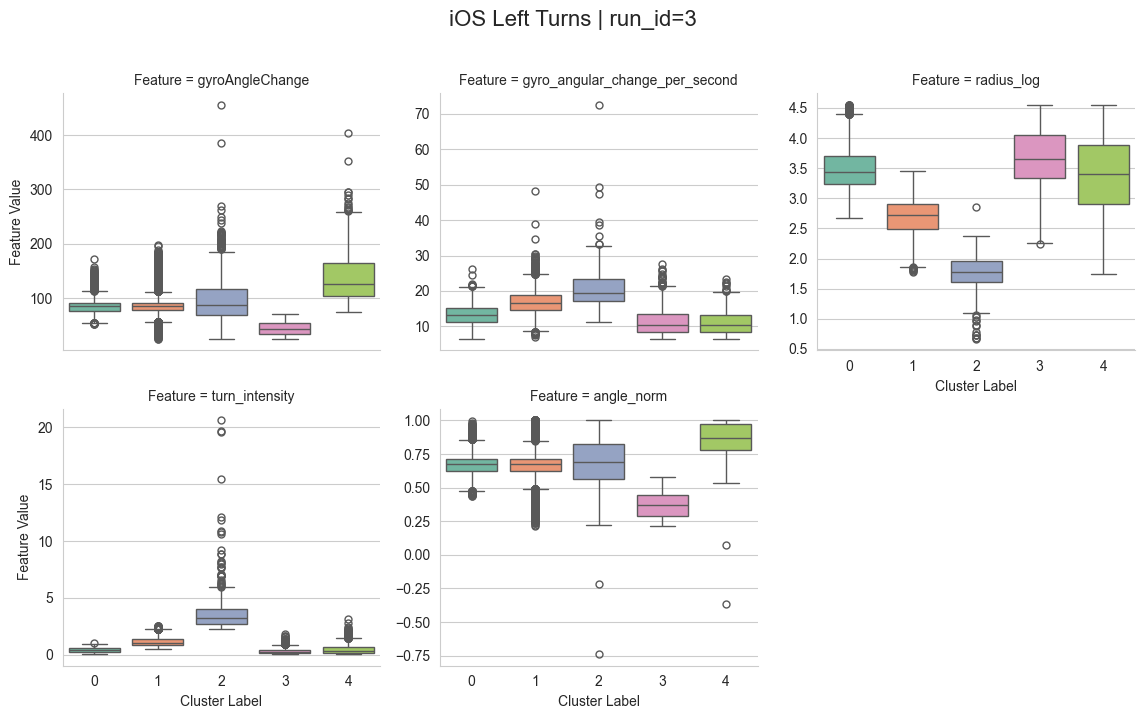

In [15]:
# --- CONFIG ---
runs_to_plot = [0, 1, 2, 3]          # run_id values you care about
plot_cols = ['gyroAngleChange',
             'gyro_angular_change_per_second',
             'radius_log',
             'turn_intensity',
             'angle_norm']

# --- helpers ---------------------------------------------------------------
def build_clusterer(row):
    model = row['model']
    if model == 'kmeans':
        return KMeans(n_clusters=int(row['clust. #']), random_state=42)
    if model == 'dbscan':
        return DBSCAN(eps=float(row['HP (eps)']),
                      min_samples=int(row['HP (min_samp)']),
                      n_jobs=-1)
    if model == 'hdbscan':
        return hdbscan.HDBSCAN(min_samples=int(row['HP (min_samp)']),
                               min_cluster_size=int(row['HP (min_clust)'])
                               if pd.notna(row['HP (min_clust)']) else None)
    raise ValueError(f"Unknown model '{model}' for run_id {row['run_id']}")

def attach_clusters(labels):
    df_with_clusters = full_df.copy()
    df_with_clusters['Cluster_Label'] = labels
    return df_with_clusters[df_with_clusters['Cluster_Label'] != -1].copy()

# --- 1) filter the runs once -----------------------------------------------
runs = (
    filtered_results
    .loc[filtered_results['run_id'].isin(runs_to_plot)]
    .copy()
)
if runs.empty:
    raise ValueError(f"No rows found for run_id(s) {runs_to_plot}")

# fit each clusterer exactly once and cache its labels
run_labels = {}
for _, row in runs.iterrows():
    clusterer = build_clusterer(row)
    run_labels[row['run_id']] = clusterer.fit_predict(X_scaled)

# --- 2) PCA plots ----------------------------------------------------------
pca3 = PCA(n_components=3).fit_transform(X_scaled)
pca2 = PCA(n_components=2).fit_transform(X_scaled)

for _, row in runs.iterrows():
    run_id = row['run_id']
    labels = run_labels[run_id]
    core_mask = labels != -1
    noise_mask = labels == -1
    title_bits = f"{row['model']} (run_id={run_id}, k={row['clust. #']})"

    # 3D
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca3[core_mask, 0], pca3[core_mask, 1], pca3[core_mask, 2],
               c=labels[core_mask], cmap='tab10', s=30, alpha=0.8)
    if noise_mask.any():
        ax.scatter(pca3[noise_mask, 0], pca3[noise_mask, 1], pca3[noise_mask, 2],
                   c='lightgray', s=15, alpha=0.4, label='Noise')
    ax.set_title(f"{title_bits} | Gini={row['Gini']:.3f} noise={row['noise %']:.1f}%")
    ax.set_xlabel('PCA 1'); ax.set_ylabel('PCA 2'); ax.set_zlabel('PCA 3')
    plt.tight_layout(); plt.show()

    # 2D
    plt.figure(figsize=(8, 6))
    plt.scatter(pca2[core_mask, 0], pca2[core_mask, 1],
                c=labels[core_mask], cmap='tab10', s=30, alpha=0.8, label='Clusters')
    if noise_mask.any():
        plt.scatter(pca2[noise_mask, 0], pca2[noise_mask, 1],
                    c='lightgray', s=15, alpha=0.4, label='Noise')
    plt.title(f"{title_bits} | PCA2D")
    plt.xlabel('PCA 1'); plt.ylabel('PCA 2'); plt.legend(); plt.tight_layout(); plt.show()

# --- 3) Box plots ----------------------------------------------------------
for _, row in runs.iterrows():
    run_id = row['run_id']
    labels = run_labels[run_id]
    df_plot = attach_clusters(labels)
    df_plot['Cluster_Label'] = df_plot['Cluster_Label'].astype('category')

    melt_cols = [c for c in plot_cols if c in df_plot.columns]
    if not melt_cols:
        raise ValueError("No overlap between plot_cols and df columns.")

    df_melted = df_plot[['Cluster_Label'] + melt_cols].melt(
        id_vars='Cluster_Label', var_name='Feature', value_name='Value'
    )

    sns.set_style('whitegrid')
    g = sns.catplot(
        data=df_melted,
        x='Cluster_Label',
        y='Value',
        col='Feature',
        kind='box',
        col_wrap=3,
        palette='Set2',
        sharey=False,
        height=3.5,
        aspect=1.1
    )
    g.fig.suptitle(f'iOS Left Turns | run_id={run_id}', y=1.02, fontsize=16)
    g.set_axis_labels('Cluster Label', 'Feature Value')
    plt.tight_layout()
    plt.show()
